# Analysis of Quenching

**Questions:** 
1. What is the optimal time, H2O2 concentration, and heat/light conditon for efficient signal removal.
2. How does autofluorescence change over repeated quenching reactions?
3. Is autofluorescence decrease due to repeated imaging, or quenching itself?

**Samples:** 

***Experiment 1***

Six adjacent sections of normal pancreas were processed with the cyclif IF tissue processing protocol. Three were stained with an antibody cocktail, and three were left as no-antbody controls. Slides we repeatedly quenched for 15 minutes and imaged. Quenching solution contained 3%, 4.5% and 6% H2O2.

***Experiment 2***

Four adjacent sections of breast cancer were processed, three were stained with strong antibody cocktail; one was left as no-antibody control. Stained slides were repeatedly quenched in 3% H202 for 30 minutes, one hour, or 30 minutes plus heat, respectively. Control was repeatedly quenched 30 minutes without heat. All slides imaged between every quenching interval. 

***Experiment 3***

Two adjacent sections of normal pancreas were processed and left without antibody. They were imaged before any quenching was applied. Then one was repeatedly quenched in 3% H2O2 for 30 miutes with heat, while the other was only imaged.


**Method**: Slides were imaged as described above, registered and tissue area was segmented out based on flooding DAPI mask. Mean intensity within the tissue area was quantififed.

Additionally, single-cell clustering results from [this notebook](https://github.com/engjen/cycIF_Validation/blob/master/Fig2_Quenching_Single_Cell.ipynb) were imported for analysis of distinct cell populations' autofluorescence change over time.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import matplotlib
import seaborn as sns
matplotlib.rcParams.update({'font.size': 15})

In [2]:
#set location of files
#os.chdir('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies/cycIF_Validation')
codedir = os.getcwd()

In [3]:
#import intensity measurement and exposure time data
ls_sample = ['4165NPanc','B1640','NPPan4165']
df_data = pd.DataFrame()
df_exp = pd.DataFrame()
for s_sample in ls_sample:
    print(s_sample)
    df = pd.read_csv(f'{codedir}/Metadata/{s_sample}/{s_sample}_MeanIntensityMeasurement.csv',index_col=0)
    df_data = df_data.append(df)
    for s_tissue in df[df.tissue.str.contains(s_sample)].tissue:
        df_exp_tissue = pd.read_csv(f'{codedir}/Metadata/{s_sample}/{s_tissue}_ExposureTimes.csv',index_col=0)
        df_exp = df_exp.append(df_exp_tissue, sort='True')


4165NPanc
B1640
NPPan4165


# Compare Single Cell Clusters

In [5]:
#import single cell clustering
df_cluster = pd.read_csv(f'{codedir}/Data/4165NPanc_AF_raw_leiden.csv',index_col=0)

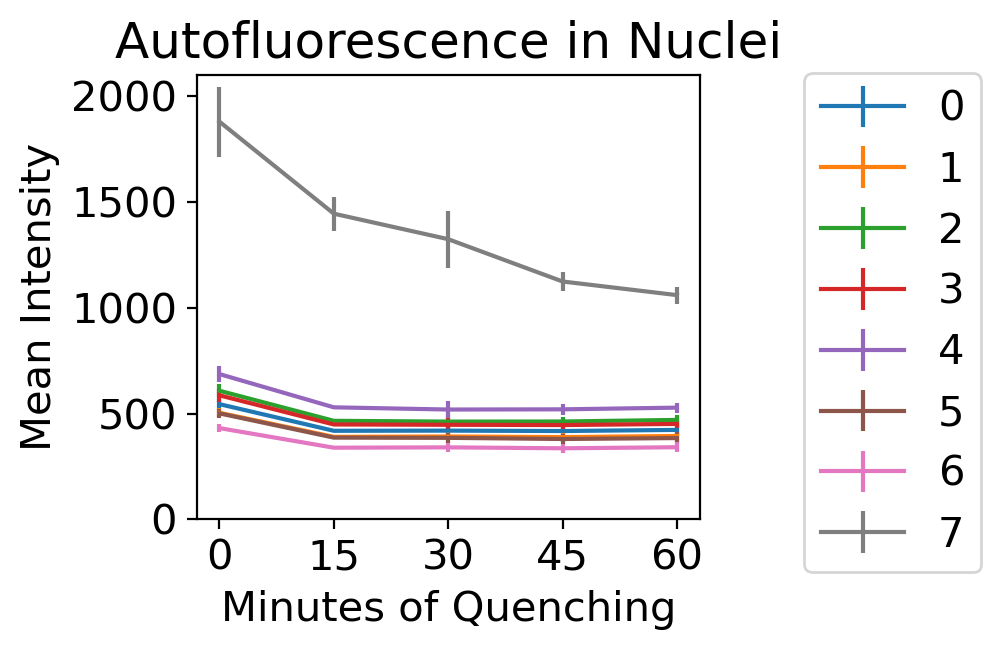

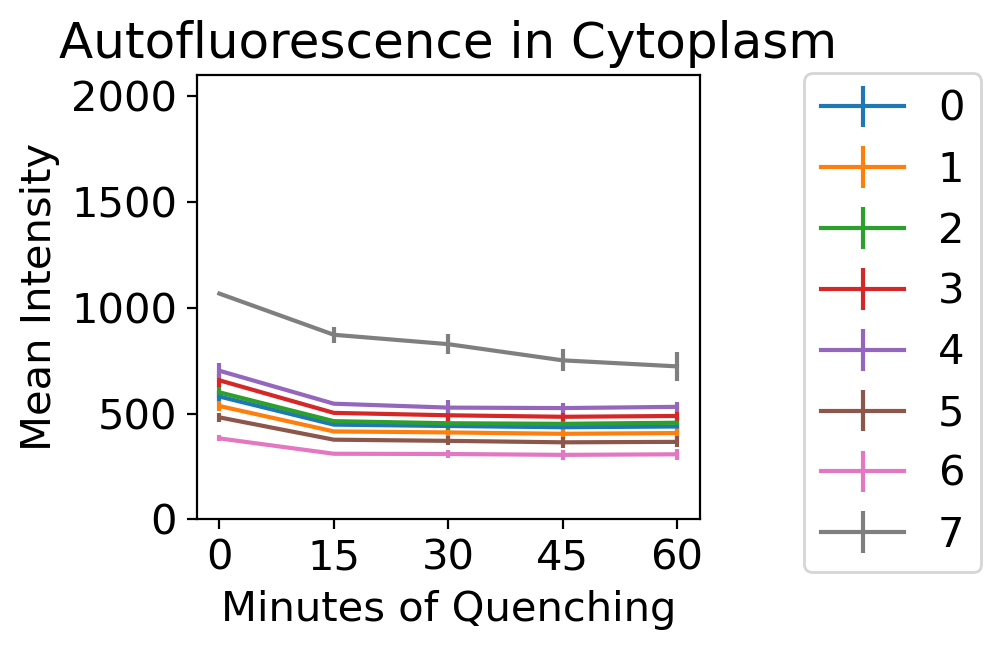

In [9]:
# plot clusters

d_color = {'nuc':'Nuclei','cyt':'Cytoplasm'}

for s_loc in ['nuc','cyt']:
    s_nloc = sorted({'nuc','cyt'} - {s_loc})[0]
    df = df_cluster.loc[:,~df_cluster.columns.str.contains(s_nloc)]
    df_std = df.groupby(['leiden','tissue']).mean().drop([8,9,10])
    df_std = df_std.groupby('leiden').std().T
    fig,ax=plt.subplots(figsize=(7,3.5),dpi=200)
    df.groupby(['leiden']).mean().drop([8,9,10]).T.plot(yerr=df_std,ax=ax)
    ax.set_xticklabels(['','0','15','30','45','60',''])
    ax.set_xlabel('Minutes of Quenching')
    ax.set_ylabel('Mean Intensity')
    ax.set_title(f'Autofluorescence in {d_color[s_loc]}',fontsize=18)
    ax.set_ylim(0,2100)
    ax.legend(loc='upper right', bbox_to_anchor=(1.6, 1.05))
    plt.tight_layout()
    fig.savefig(f'{codedir}/Figures/4165NPanc/Leiden_{s_loc}_quenching.png')

In [4]:
#add experimental condition annotation
d_condition = {'4165NPanc-73-Scene-001':'3%_stain',
 '4165NPanc-74-Scene-001':'3%_blank',
 '4165NPanc-75-Scene-001':'4.5%_stain',
 '4165NPanc-76-Scene-001':'4.5%_blank',
 '4165NPanc-77-Scene-001':'6%_stain',
 '4165NPanc-78-Scene-001':'6%_blank',
 'B1640-T8-3-Scene-001':'30min_blank',
 'B1640-T8-4-Scene-001':'60min_stain',
 'B1640-T8-5-Scene-001':'30min_stain',
 'B1640-T8-6-Scene-001':'30min+light_stain',
 'NPPan4165-65-Scene-1': '30min+light_blank',
 'NPPan4165-66-Scene-1': 'no-quench_blank',
              }
#add annotation
for key, item in d_condition.items():
    s_tissue = key.split('-Scene')[0]
    s_type = item.split('_')[1]
    s_cond = item.split('_')[0]
    s_index = (df_data[df_data.scene==key]).index
    df_data.loc[s_index,'condition'] = s_cond
    df_data.loc[s_index,'slidetype'] = s_type
    df_data.loc[s_index,'cond_type'] = item
#normalize to 50 ms exposure time
df_data['norm_result'] = (df_data.result/df_data.exposure)*50
df_data = df_data.drop_duplicates(keep='first')

# Compare Percent H2O2 

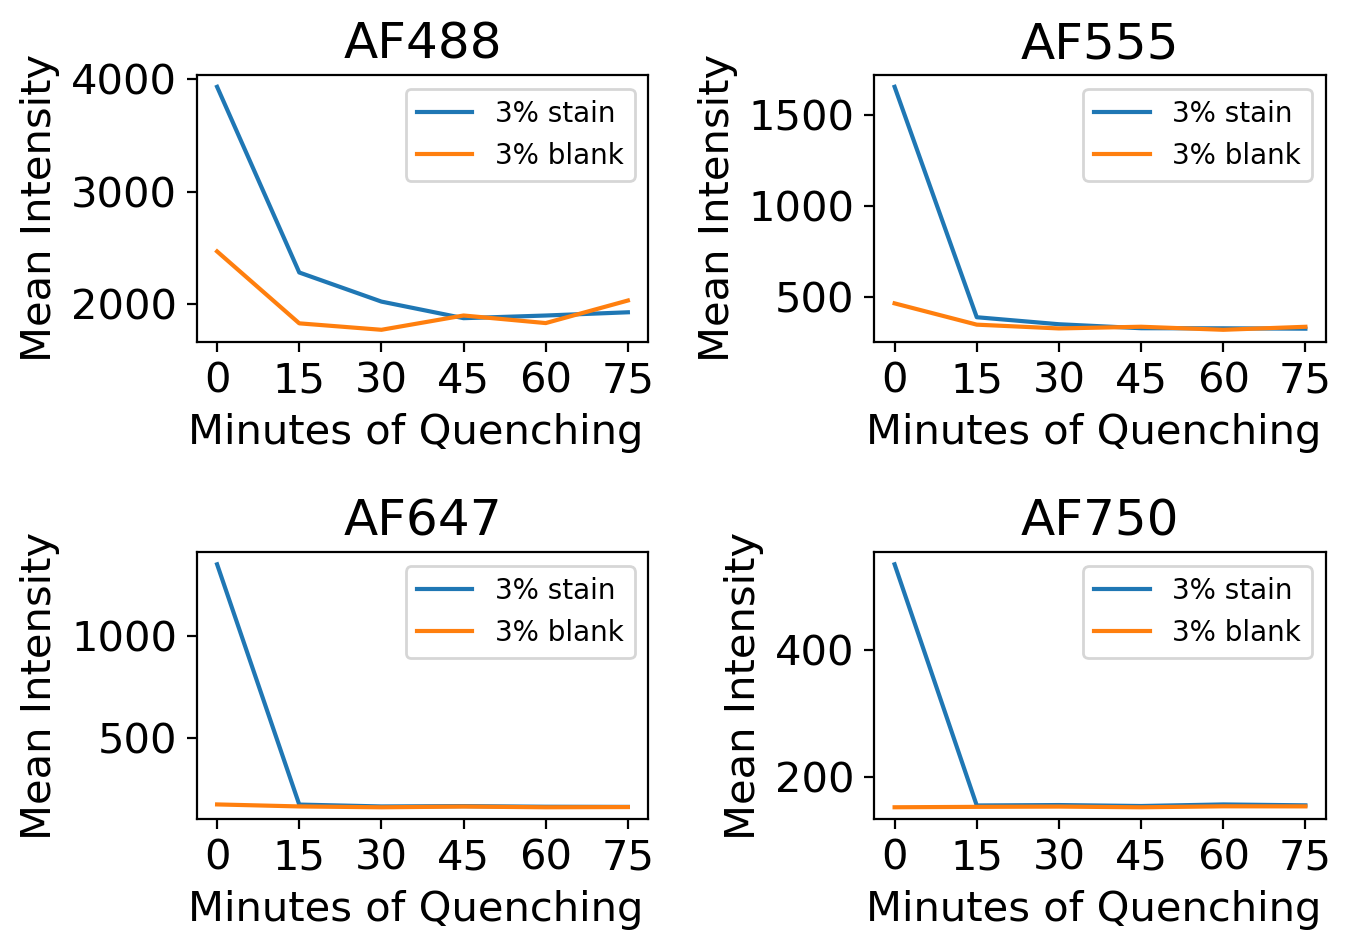

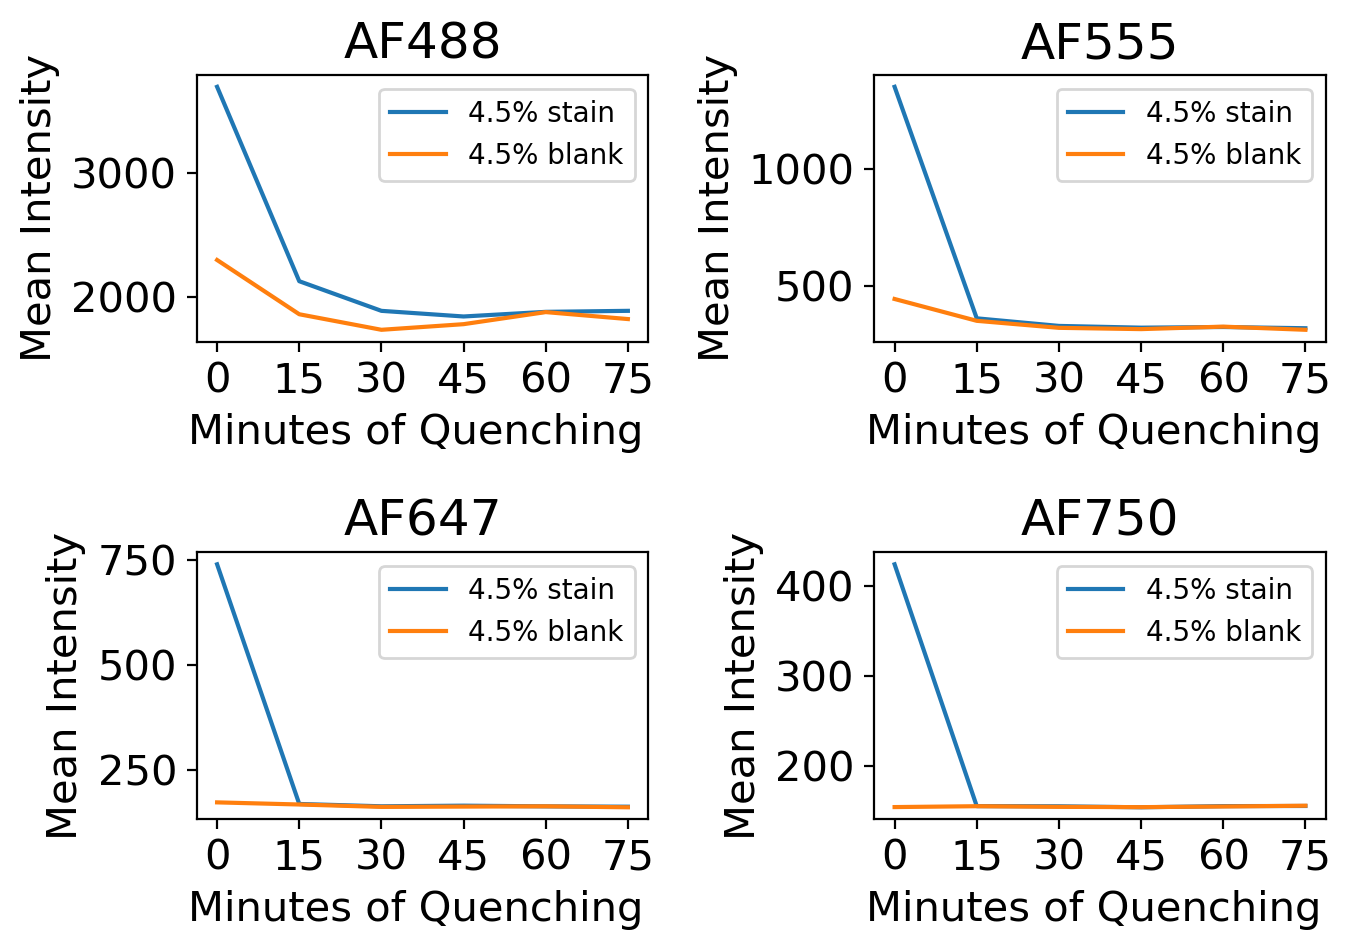

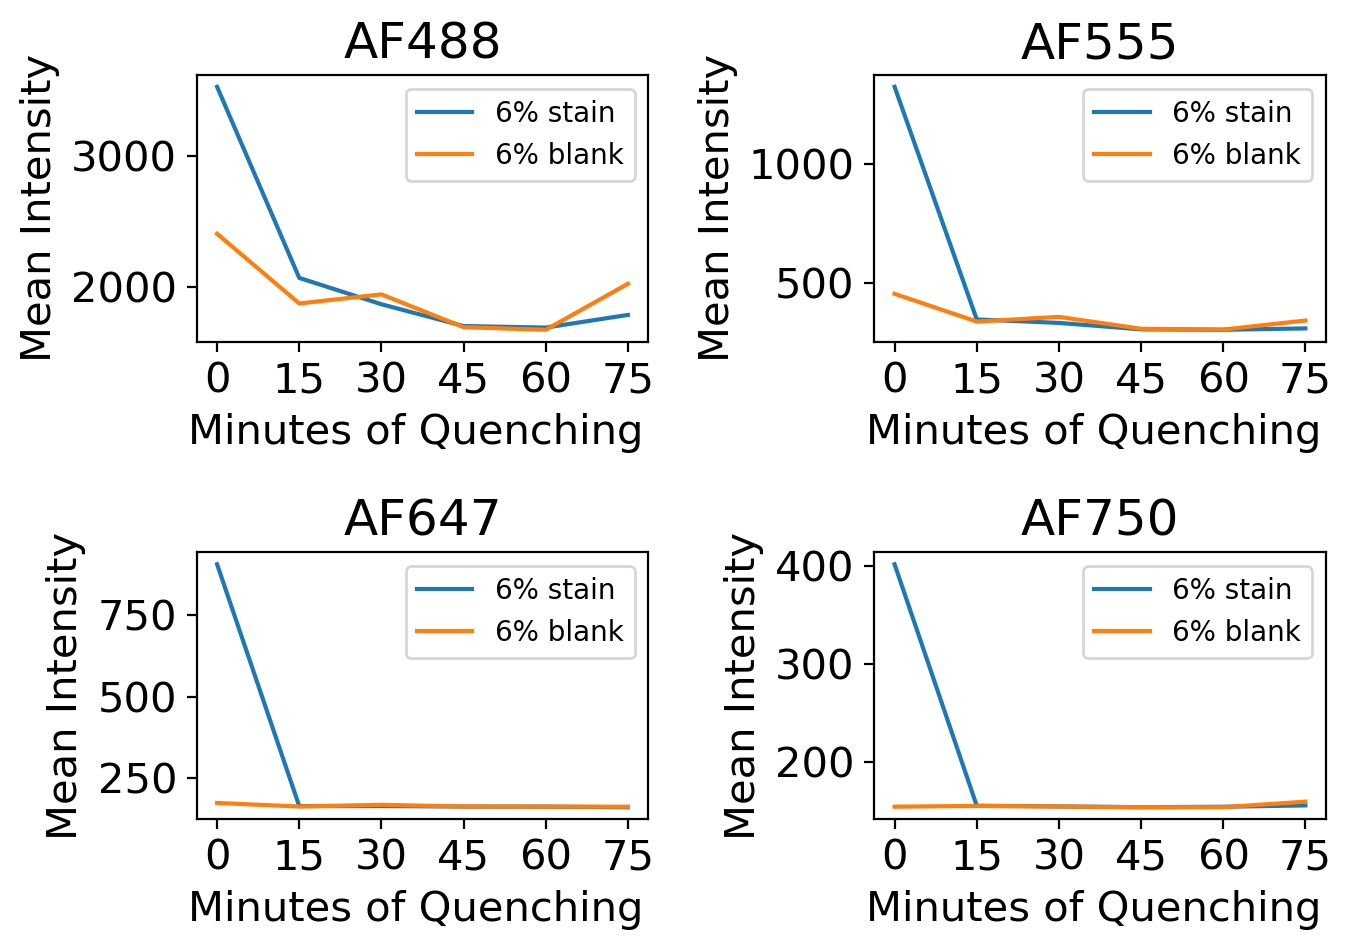

In [5]:
d_tissue = {'4165NPanc':'Time'}
d_color = {'c2':'AF488','c3':'AF555','c4':'AF647','c5':'AF750'}
for s_tissue, s_test in d_tissue.items():
    df_data_tissue = df_data[(df_data.tissue.str.find(s_tissue)==0) & (df_data.color!='c1')]
    ls_color = sorted(set(df_data_tissue.color))
    ls_cond = sorted(set(df_data_tissue.condition))
    for s_cond in ls_cond:
        fig,ax = plt.subplots(2,2, figsize=(7,5),squeeze=False,dpi=200)
        ax=ax.ravel()
        for idx,s_color in enumerate(ls_color):
            ls_legend=[]
            ls_tissue = sorted(set(df_data_tissue.tissue))
            df_tissue_cond = df_data[(df_data.color==s_color)& (df_data.condition==s_cond)]
            for s_type in ['stain','blank']:
                df_tissue = df_tissue_cond[df_tissue_cond.slidetype==s_type]
                df_tissue = df_tissue.sort_values('round_int')
                s_label = sorted(set(df_tissue.loc[:,'cond_type']))[0]
                df_tissue.norm_result.plot(ax=ax[idx])
                ls_legend= ls_legend + [s_label]
            ax[idx].set_title(d_color[s_color])
            ax[idx].set_ylabel('Mean Intensity')
            ax[idx].set_xlabel('Minutes of Quenching ')
            ax[idx].set_xticks(list(df_tissue.round_int - 1))
            ax[idx].set_xticklabels(list(((df_tissue.round_int - 1).astype(int)*15).astype(str)))
            ax[idx].legend([item.replace('_',' ') for item in ls_legend],fontsize=10)
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/{s_tissue}/vertical_{s_tissue}{s_cond}_quenching.png')

In [46]:
#how much does AF reduce in 1st quench?
for s_color in ['c2','c3','c4','c5']:
    df_test = df_data[(df_data.slidetype=='blank') & (df_data.color==s_color) &(df_data.scene.str.contains('4165NPanc-')) & (df_data.rounds.isin(['R1','R2']))]
    i_result = df_test.groupby('rounds').mean().result.loc['R2']/df_test.groupby('rounds').mean().result.loc['R1']
    print(f'{s_color}: {1-i_result}')
    ls_single = []
    for s_tissue in ['4165NPanc-74', '4165NPanc-76', '4165NPanc-78']:
        i_single = df_test[(df_test.tissue==s_tissue) & (df_test.rounds=='R2')].result[0]/(df_test[(df_test.tissue==s_tissue) & (df_test.rounds=='R1')].result[0])
        ls_single.append(i_single)
    print(np.std(ls_single))

c2: 0.22499058768933233
0.028377297570229
c3: 0.24112422836309477
0.020625549853008896
c4: 0.049325740217636804
0.014493206049719725
c5: -0.0051660603140097905
0.0008401171442017876


In [26]:
#how much does AF reduce in 1st quench?
for s_color in ['c2','c3','c4','c5']:
    df_test = df_data[(df_data.slidetype=='blank') & (df_data.color==s_color) &(df_data.scene.str.contains('4165NPanc-')) & (df_data.rounds.isin(['R1','R2']))]
    i_result = df_test.groupby('rounds').std().result.loc['R2']/df_test.groupby('rounds').std().result.loc['R1']
    print(f'{s_color}: {i_result}')

c2: 0.27664223860786596
c3: 0.6145552543670462
c4: 2.5145708624220626
c5: 1.099150434223848


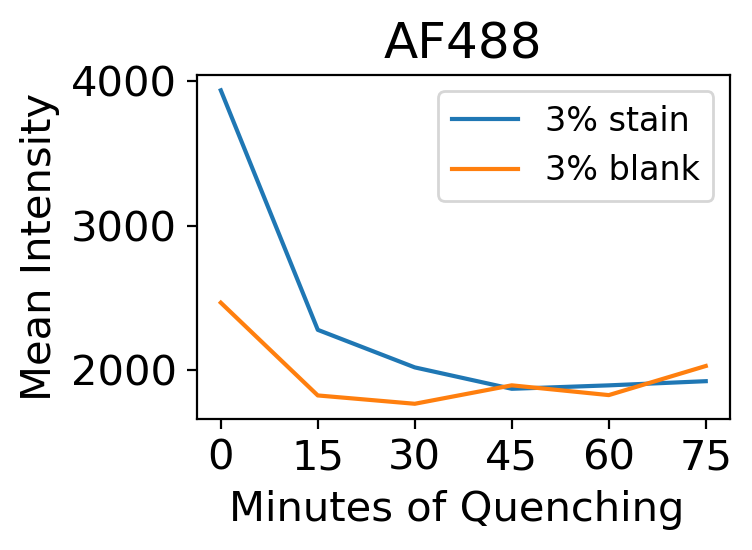

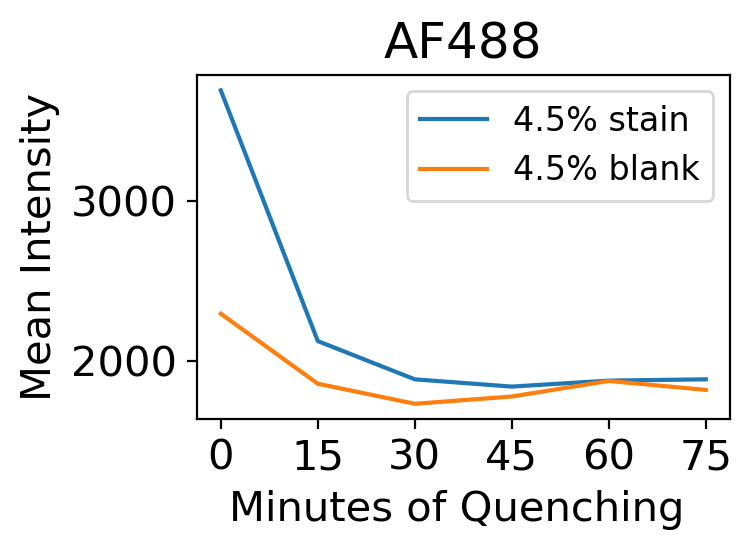

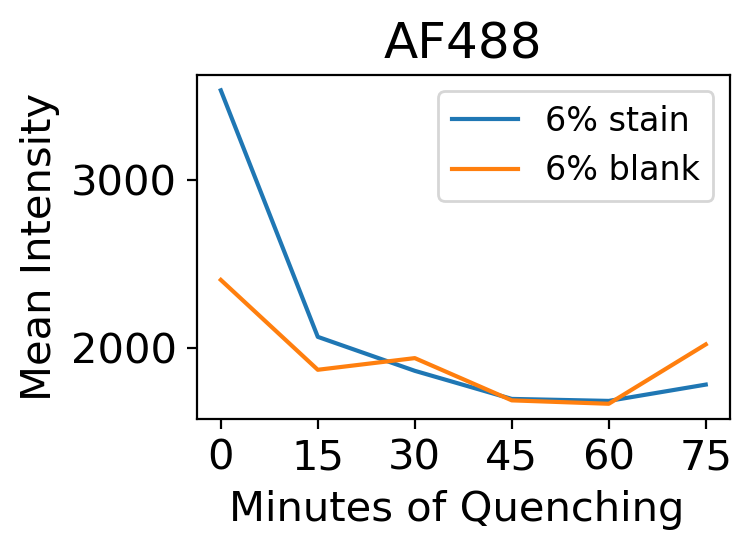

In [36]:
# just AF488
d_tissue = {'4165NPanc':'Time'}
d_color = {'c2':'AF488','c3':'AF555','c4':'AF647','c5':'AF750'}
for s_tissue, s_test in d_tissue.items():
    df_data_tissue = df_data[(df_data.tissue.str.find(s_tissue)==0) & (df_data.color!='c1')]
    ls_color = sorted(set(df_data_tissue.color))
    ls_cond = sorted(set(df_data_tissue.condition))
    for s_cond in ls_cond:
        fig,ax = plt.subplots(figsize=(4,3),squeeze=False,dpi=200)
        ax=ax.ravel()
        for idx,s_color in enumerate(ls_color):
            ls_legend=[]
            ls_tissue = sorted(set(df_data_tissue.tissue))
            df_tissue_cond = df_data[(df_data.color==s_color)& (df_data.condition==s_cond)]
            for s_type in ['stain','blank']:
                df_tissue = df_tissue_cond[df_tissue_cond.slidetype==s_type]
                df_tissue = df_tissue.sort_values('round_int')
                s_label = sorted(set(df_tissue.loc[:,'cond_type']))[0]
                df_tissue.norm_result.plot(ax=ax[idx])
                ls_legend= ls_legend + [s_label]
            ax[idx].set_title(d_color[s_color])
            ax[idx].set_ylabel('Mean Intensity')
            ax[idx].set_xlabel('Minutes of Quenching ')
            ax[idx].set_xticks(list(df_tissue.round_int - 1))
            ax[idx].set_xticklabels(list(((df_tissue.round_int - 1).astype(int)*15).astype(str)))
            ax[idx].legend([item.replace('_',' ') for item in ls_legend],fontsize=12)
            break
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/{s_tissue}/AF488_{s_tissue}{s_cond}_quenching.png')

# Compare Time and Addition of Incandescent Light

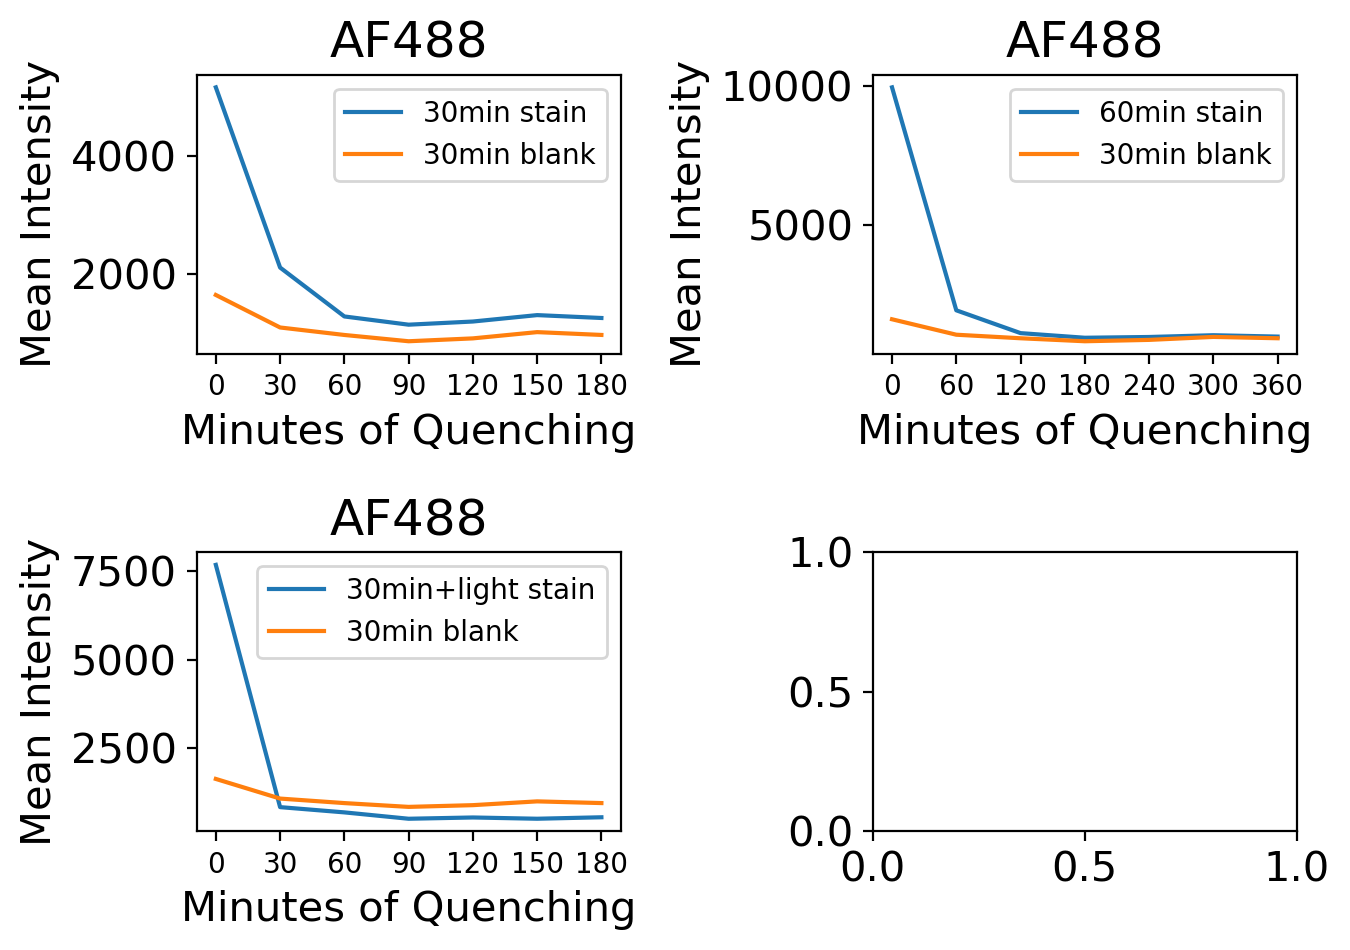

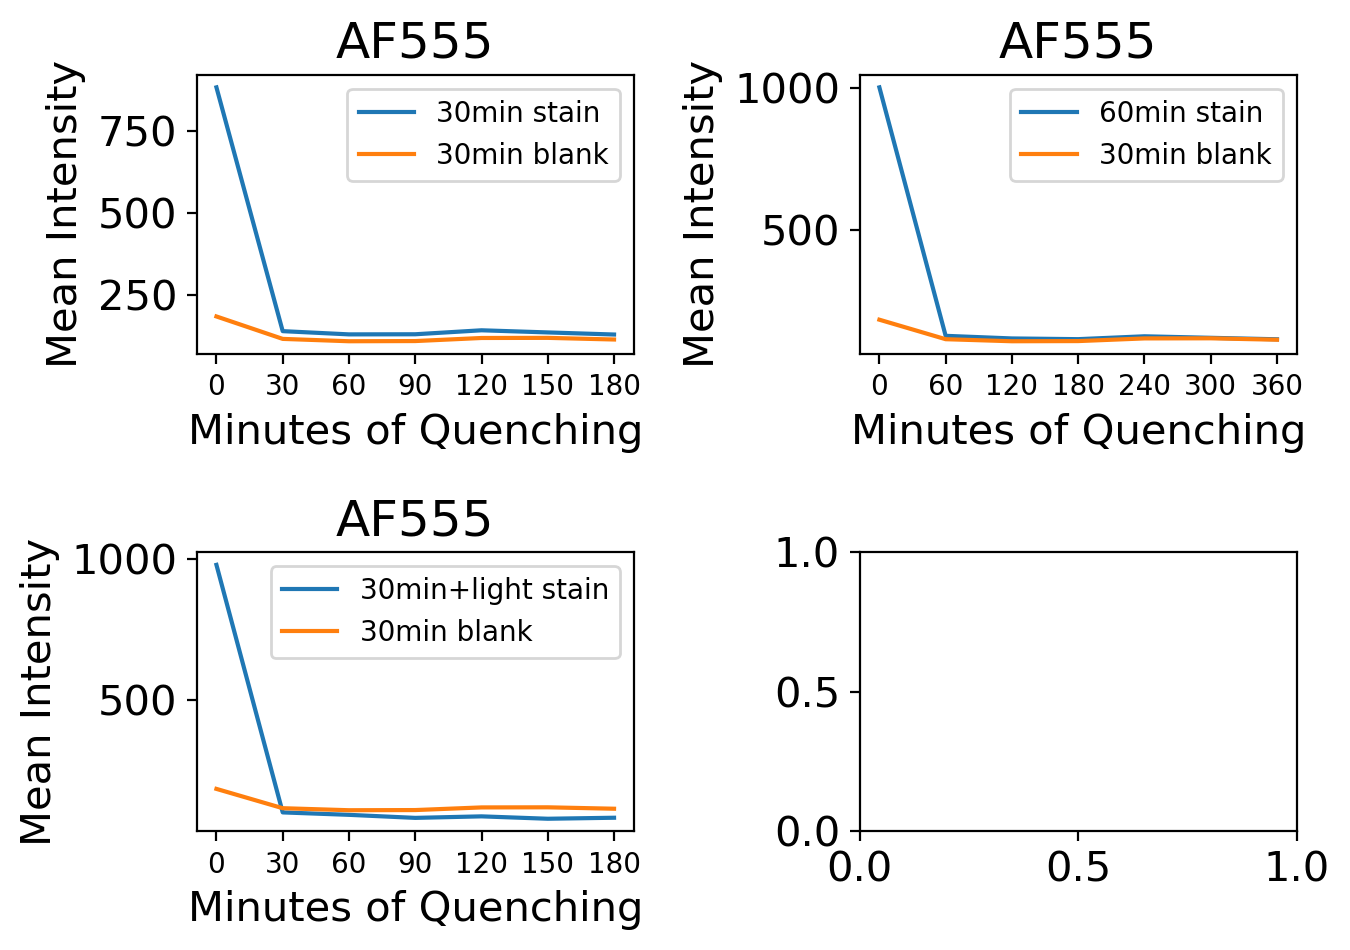

In [26]:
d_tissue = {'B1640':'Light'}
d_color = {'c2':'AF488','c3':'AF555','c4':'AF647','c5':'AF750'}
for s_tissue, s_test in d_tissue.items():
    df_data_tissue = df_data[(df_data.tissue.str.contains(s_tissue)) & (df_data.color!='c1')]
    ls_color = sorted(set(df_data_tissue.color))
    ls_cond = ['30min', '60min', '30min+light']
    for s_color in ls_color:
        fig,ax = plt.subplots(2,2, figsize=(7,5),squeeze=False,dpi=200)
        ax=ax.ravel()
        for idx,s_cond in enumerate(ls_cond):
            ls_legend=[]
            ls_tissue = sorted(set(df_data_tissue.tissue))
            df_tissue_cond = df_data[(df_data.color==s_color)& (df_data.condition==s_cond)]
            for s_type in ['stain','blank']:
                if s_type == 'blank':
                    df_tissue = df_data[(df_data.cond_type=='30min_blank') & (df_data.color==s_color)]
                else:
                    df_tissue = df_tissue_cond[df_tissue_cond.slidetype==s_type]
                df_tissue = df_tissue.sort_values('round_int')
                s_label = sorted(set(df_tissue.loc[:,'cond_type']))[0]
                df_tissue.norm_result.plot(ax=ax[idx])
                ls_legend= ls_legend + [s_label]
            ax[idx].set_title(d_color[s_color])
            ax[idx].set_ylabel('Mean Intensity')
            ax[idx].set_xlabel('Minutes of Quenching')
            ax[idx].set_xticks(list(df_tissue.round_int - 1))
            fontdict = {'fontsize': 10}
            ax[idx].set_xticklabels(list(((df_tissue.round_int - 1).astype(int)*30).astype(str)),fontdict=fontdict)
            if idx==1:
                ax[idx].set_xticklabels(list(((df_tissue.round_int - 1).astype(int)*60).astype(str)),fontdict=fontdict)
            ax[idx].legend([item.replace('_',' ') for item in ls_legend],fontsize=10)
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/{s_tissue}/vertical_{s_tissue}{s_color}_quenching.png')

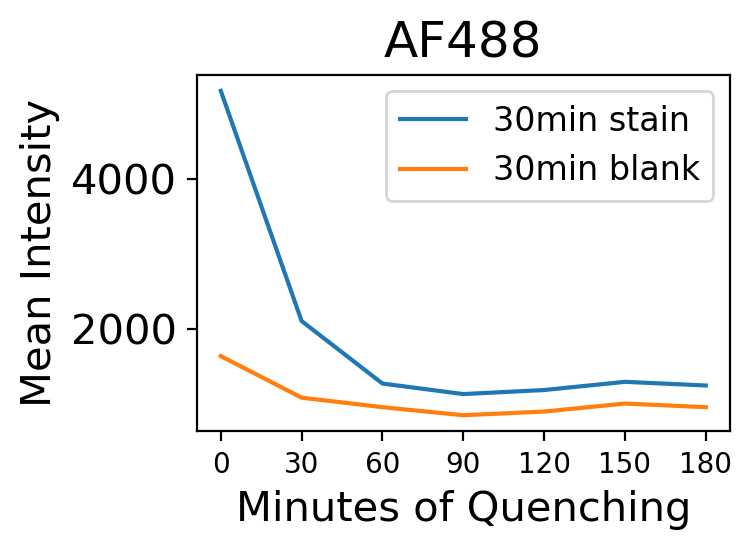

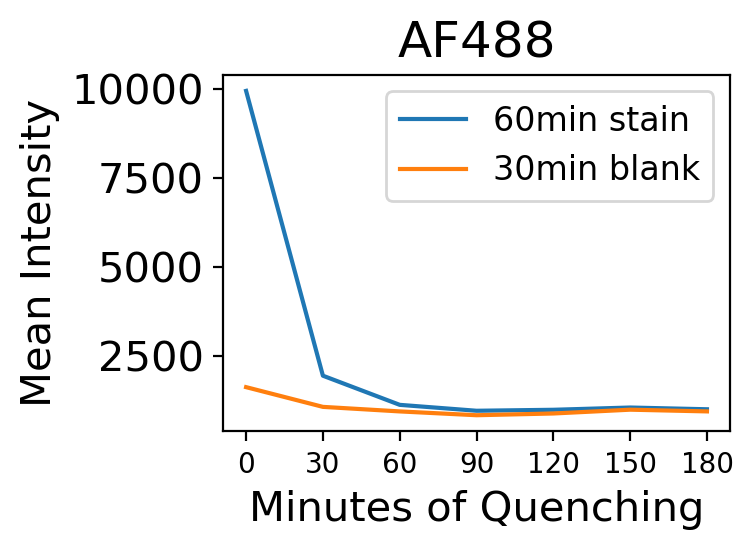

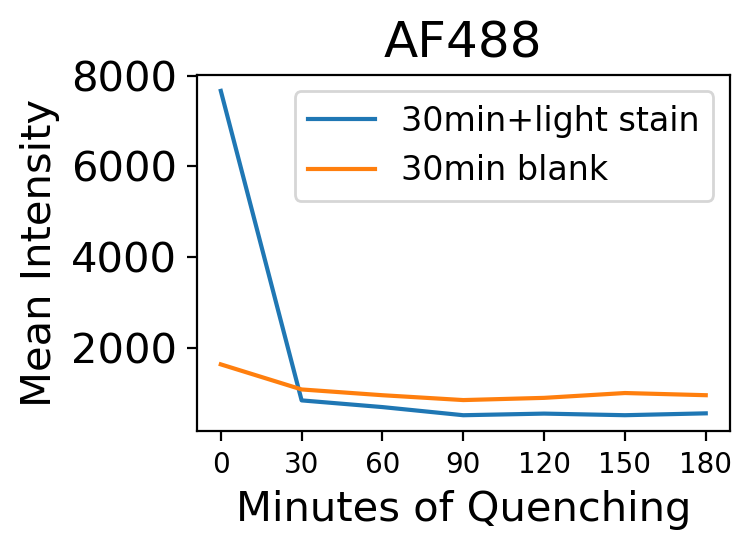

In [37]:
#just AF488
d_tissue = {'B1640':'Light'}
d_color = {'c2':'AF488','c3':'AF555','c4':'AF647','c5':'AF750'}
for s_tissue, s_test in d_tissue.items():
    df_data_tissue = df_data[(df_data.tissue.str.contains(s_tissue)) & (df_data.color!='c1')]
    ls_color = sorted(set(df_data_tissue.color))
    ls_cond = ['30min', '60min', '30min+light']
    for s_cond in ls_cond:
        fig,ax = plt.subplots(figsize=(4,3),squeeze=False,dpi=200)
        ax=ax.ravel()
        for idx,s_color in enumerate(ls_color):
            ls_legend=[]
            ls_tissue = sorted(set(df_data_tissue.tissue))
            df_tissue_cond = df_data[(df_data.color==s_color)& (df_data.condition==s_cond)]
            for s_type in ['stain','blank']:
                if s_type == 'blank':
                    df_tissue = df_data[(df_data.cond_type=='30min_blank') & (df_data.color==s_color)]
                else:
                    df_tissue = df_tissue_cond[df_tissue_cond.slidetype==s_type]
                df_tissue = df_tissue.sort_values('round_int')
                s_label = sorted(set(df_tissue.loc[:,'cond_type']))[0]
                df_tissue.norm_result.plot(ax=ax[idx])
                ls_legend= ls_legend + [s_label]
            ax[idx].set_title(d_color[s_color])
            ax[idx].set_ylabel('Mean Intensity')
            ax[idx].set_xlabel('Minutes of Quenching')
            ax[idx].set_xticks(list(df_tissue.round_int - 1))
            fontdict = {'fontsize': 10}
            ax[idx].set_xticklabels(list(((df_tissue.round_int - 1).astype(int)*30).astype(str)),fontdict=fontdict)
            if idx==1:
                ax[idx].set_xticklabels(list(((df_tissue.round_int - 1).astype(int)*60).astype(str)),fontdict=fontdict)
            ax[idx].legend([item.replace('_',' ') for item in ls_legend],fontsize=12)
            break
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/{s_tissue}/AF488_{s_tissue}{s_color}{s_cond}_quenching.png')

# Compare Blank Slide Quenched and Imaged vs. Imaged Only

Does the reducion in autofluorescnce come from the quenching or imaging process (i.e. is it chemical or photo bleaching of autofluorescnce) 

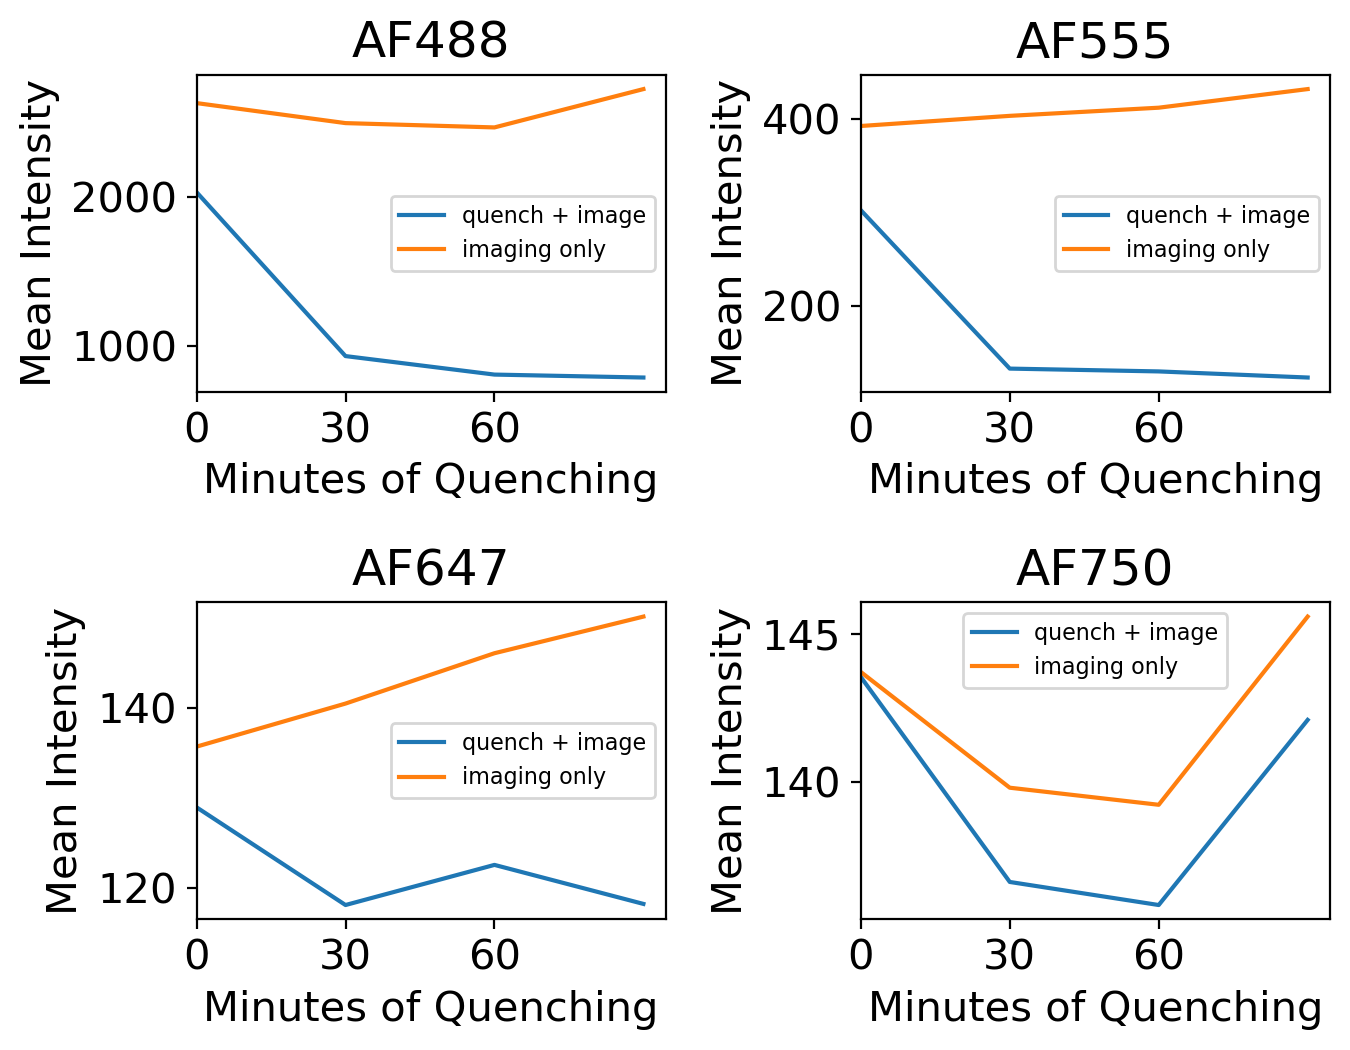

In [29]:
d_tissue = {'NPPan4165':'No Quench Ctrl'}
d_color = {'c2':'AF488','c3':'AF555','c4':'AF647','c5':'AF750'}
d_label = {'no-quench_blank':'imaging only','30min+light_blank':'quench + image'}
for s_tissue, s_test in d_tissue.items():
    df_data_tissue = df_data[(df_data.tissue.str.contains(s_tissue)) & (df_data.color!='c1')]
    ls_color = sorted(set(df_data_tissue.color))
    fig,ax = plt.subplots(2,2, figsize=(7,5.5),squeeze=False,dpi=200)
    ax=ax.ravel()
    for idx,s_color in enumerate(ls_color):
        ls_legend=[]
        ls_tissue = sorted(set(df_data_tissue.tissue))
        for s_tissue in ls_tissue:
            df_tissue = df_data[(df_data.tissue==s_tissue) & (df_data.color==s_color)]
            df_tissue = df_tissue.sort_values('round_int')
            s_label = d_label[sorted(set(df_tissue.loc[:,'cond_type']))[0]]
            df_tissue.norm_result.plot(ax=ax[idx])
            ls_legend= ls_legend + [s_label]
        ax[idx].set_title(d_color[s_color])
        ax[idx].set_ylabel('Mean Intensity')
        ax[idx].set_xlabel('Minutes of Quenching')
        ax[idx].set_xticks(list(df_tissue.round_int - 1))
        ax[idx].set_xticklabels(list(((df_tissue.round_int - 1)*30).astype(int).astype(str)))
        ax[idx].legend([item.replace('_',' ') for item in ls_legend],fontsize=8)
        ax[idx].set_xlim(left=0)
    plt.tight_layout()
    fig.savefig(f'{codedir}/Figures/NPPan4165/vertical_{s_tissue}_imagingonly.png')

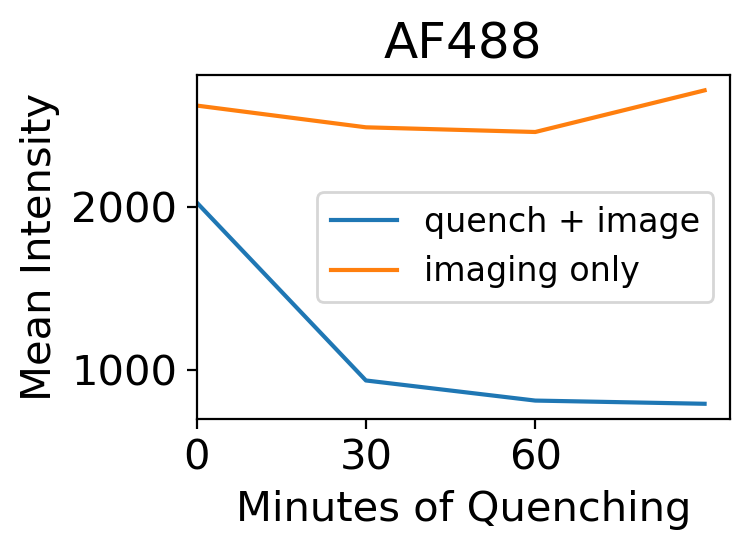

In [34]:
#just AF488
d_tissue = {'NPPan4165':'No Quench Ctrl'}
d_color = {'c2':'AF488','c3':'AF555','c4':'AF647','c5':'AF750'}
d_label = {'no-quench_blank':'imaging only','30min+light_blank':'quench + image'}
for s_tissue, s_test in d_tissue.items():
    df_data_tissue = df_data[(df_data.tissue.str.contains(s_tissue)) & (df_data.color!='c1')]
    ls_color = sorted(set(df_data_tissue.color))
    fig,ax = plt.subplots(figsize=(4,3),squeeze=False,dpi=200)
    ax=ax.ravel()
    for idx,s_color in enumerate(ls_color):
        ls_legend=[]
        ls_tissue = sorted(set(df_data_tissue.tissue))
        for s_tissue in ls_tissue:
            df_tissue = df_data[(df_data.tissue==s_tissue) & (df_data.color==s_color)]
            df_tissue = df_tissue.sort_values('round_int')
            s_label = d_label[sorted(set(df_tissue.loc[:,'cond_type']))[0]]
            df_tissue.norm_result.plot(ax=ax[idx])
            ls_legend= ls_legend + [s_label]
        ax[idx].set_title(d_color[s_color])
        ax[idx].set_ylabel('Mean Intensity')
        ax[idx].set_xlabel('Minutes of Quenching')
        ax[idx].set_xticks(list(df_tissue.round_int - 1))
        ax[idx].set_xticklabels(list(((df_tissue.round_int - 1)*30).astype(int).astype(str)))
        ax[idx].legend([item.replace('_',' ') for item in ls_legend],fontsize=12)
        ax[idx].set_xlim(left=0)
        break
    plt.tight_layout()
    fig.savefig(f'{codedir}/Figures/NPPan4165/AF488_{s_tissue}_imagingonly.png')

# Temperature of Buffer under Various Conditions

Our intepretation is that the heat comes from the light, but also from the exotermic reaction of H2O2 oxidation.

In [66]:
df_temp = pd.read_csv(f'{codedir}/Data/TemperatureExperiments.csv',index_col = 0)

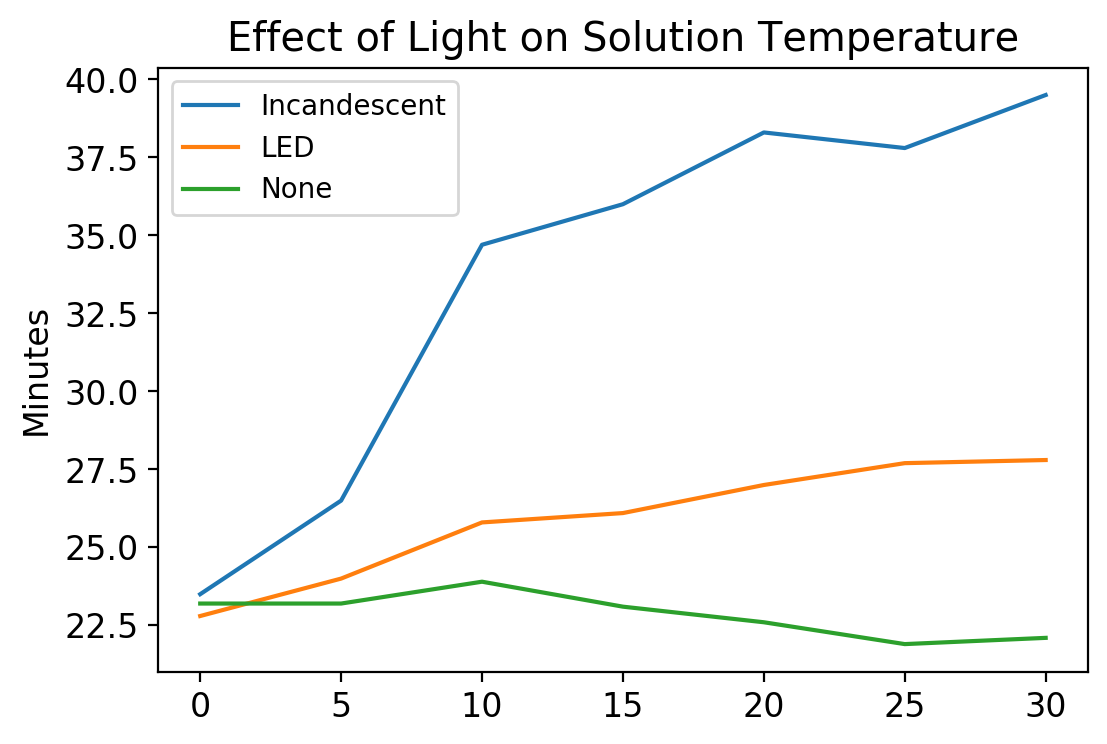

In [67]:
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(dpi=200)
df_temp.iloc[:7,[0,2,4]].plot(kind='line', ax=ax)
ax.set_ylabel('Temp (C)')
ax.set_ylabel('Minutes')
ax.legend(labels = [item.split('_')[0] for item in ax.get_legend_handles_labels()[1]],fontsize=10)
ax.set_title('Effect of Light on Solution Temperature')
fig.savefig(f'{codedir}/Figures/Other/EffectofLightonQuenchTemperature.png')

In [68]:
df_temp.iloc[:7,:]

,Incandescent_Cold_H2O2,Incandescent_RT_Buffer,LED_Cold_H2O2,LED_RT_Buffer,None_Cold_H2O2,None_RT_H2O2
0,23.5,24.1,22.8,23.0,23.2,23.5
5,26.5,26.6,24.0,24.2,23.2,23.1
10,34.7,32.4,25.8,25.6,23.9,22.5
15,36.0,34.4,26.1,25.4,23.1,22.8
20,38.3,36.5,27.0,26.8,22.6,22.4
25,37.8,34.8,27.7,27.8,21.9,22.1
30,39.5,36.8,27.8,28.9,22.1,21.8


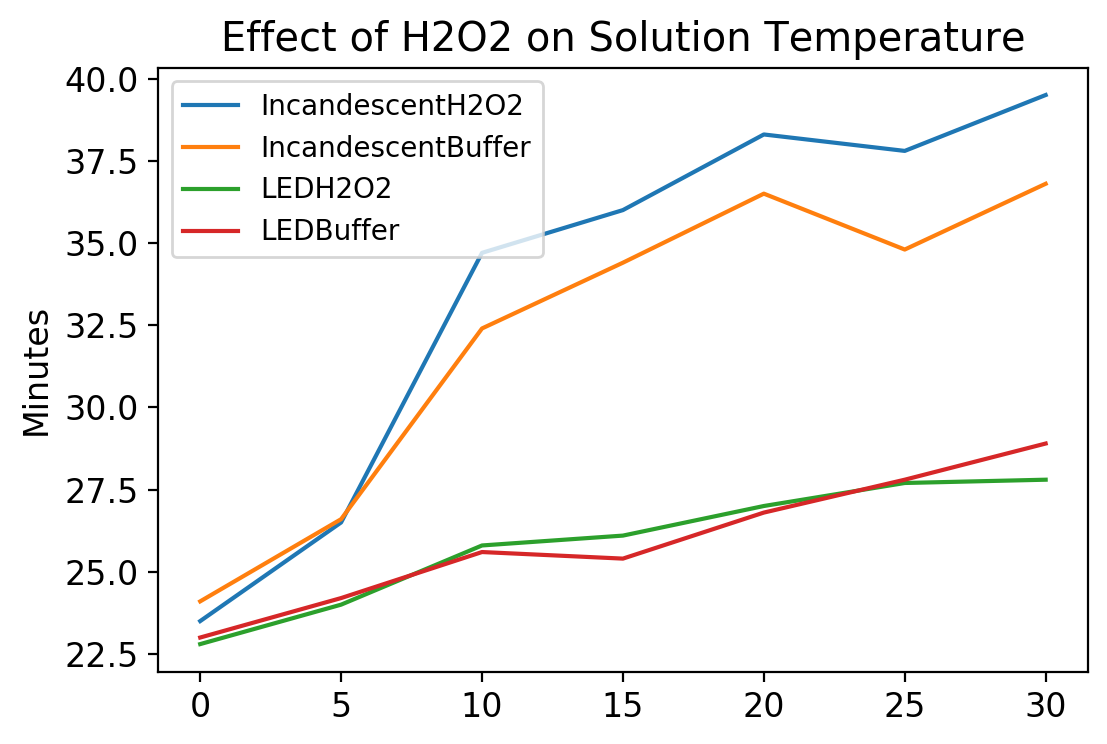

In [69]:
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(dpi=200)
df_temp.iloc[:7,[0,1,2,3]].plot(kind='line', ax=ax)
ax.set_ylabel('Temp (C)')
ax.set_ylabel('Minutes')
ax.legend(labels = [item.split('_')[0] + item.split('_')[2] for item in ax.get_legend_handles_labels()[1]],fontsize=10)
ax.set_title('Effect of H2O2 on Solution Temperature')
fig.savefig(f'{codedir}/Figures/Other/EffectofH2O2onQuenchTemperature.png')

# Temperature result interpretation

The incandescent light physically heats the solution, but also increases the rate of H2O2 oxidation and exothermic heat production. This effect is not seen with LED light.

We also observed the most bubbles in the Incandescent/H2O2 solution, suggesting the highest level of oxidation.